<a href="https://colab.research.google.com/github/PierfrancescoElia/AICyberLabs/blob/main/Lab02/lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Model Engineering

| Member | ID |
| -- | -- |
| Alessandro Meneghini| s332228 |
| Pierfrancesco Elia | s331497 |
| Ankesh Porwal | s328746 |


In [42]:
# importing libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import time
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

## Task 1: BoW Approaches

Each sequence of processes is a string, all the processes are words in a centence –> Fit a
CountVectorizer object from sklearn!
- How many columns do you have after applying the CountVectorizer? What does that
number represent?
- What does each row represent? Can you still track the order of the processes (how they
were called)?
- Do you have out-of-vocabulary from the test set? If yes, how many? How does CountVec-
torizer handle them?
- Try to fit a classifier (at your choice, shallow deep or neural network). Report how you
chose the hyperparameters of your classifier, and the final performance on the test set.

In [ ]:
# importing dataset
dataset_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab02/train.json'
train_df = pd.read_json(dataset_url)

dataset_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab02/test.json'
test_df = pd.read_json(dataset_url)

train_df.head()

,md5hash,api_call_sequence,is_malware
0,aaec2a99e23b2478ce5ec7f9b43c840c,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1
1,14a9db02dd903a76adb275cf45d10413,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1
2,70f77a07109abab1983d98214f4eb199,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
3,fa67eebd3047eb2a4c9379623219d58d,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1
4,d9209cdfe4fd24c6f2a17acdafa558a5,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1


Let's join api_call_squence

In [ ]:
train_df["api_sequence_str"] = train_df["api_call_sequence"].apply(lambda x: " ".join(x))
test_df["api_sequence_str"] = test_df["api_call_sequence"].apply(lambda x: " ".join(x))
# train_df["api_sequence_str"]

In [ ]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df["api_sequence_str"])
X_test = vectorizer.transform(test_df["api_sequence_str"])  # transform so that out-of-vocaboulary are ignored correctly

y_train = train_df["is_malware"]
y_test = test_df["is_malware"]

how many vocab do i have

In [ ]:
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")

Number of features: 253


Do you have out-of-vocabulary in the test set? How many?

In [ ]:
test_vocab = set(api for seq in test_df["api_call_sequence"] for api in seq)
train_vocab = set(api for seq in train_df["api_call_sequence"] for api in seq)
oov_words = test_vocab - train_vocab
print("Out-of-Vocabulary Words:", oov_words)
print(f"There are {len(oov_words)} out-of-vocabulary words")

Out-of-Vocabulary Words: {'NtDeleteKey', 'WSARecv', 'ObtainUserAgentString', 'WSASocketA', 'ControlService'}
There are 5 out-of-vocabulary words


STEP 4

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Goodware", "Malware"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Goodware       0.64      0.28      0.39       324
     Malware       0.98      1.00      0.99     12839

    accuracy                           0.98     13163
   macro avg       0.81      0.64      0.69     13163
weighted avg       0.97      0.98      0.97     13163


Confusion Matrix:
[[   92   232]
 [   51 12788]]


How many columns after CountVectorizer? 253\
What does that number represent? The size of the vocabulary (i.e., number of distinct API calls across training samples)

What does each row represent? A vectorized version of a malware/goodware API sequence\
Can you still track the order of the processes (how they were called)? No, it's not possible anymore.

Do you have out-of-vocabulary in the test set? How many? 5

How does CountVectorizer handle OOV? It simply ignores words not present in the training vocabulary\
What classifier did you choose and why? Logistic Regression for a simple baseline with BoW

Final performance? Accuracy, Precision, Recall, F1 (da classification_report)

## Task 2: Feed Forward Neural Network

Now, obtain some stats on the number of processes called per sample.
- Do you have the same number of calls for each sample? Is the training distribution the
same as the test one? shorter than the testing ones.
- Let’s say that you really want to use a simple FeedForward neural network to solve the
problem. Can a Feedforward Neural Network handle a variable number of elements?
Why?
- Which technique do you adopt to bring everything to a fixed size during training? What
happens if at test time you have more processes to handle?
- Each process is actually a string: first solve the problem using sequential identifiers, then
try using learnable embeddings. Use a FeedForward network on both cases. Report how
you selected the hyper-parameters of your final model, and justify your choices. Can
you obtain the same results for the two alternatives (sequential identifiers and learnable
embeddings)?

Articulate (report results, whether one training was longer/more unstable than the other,
etc.)

In [ ]:
train_df.head()
test_df.head()

,md5hash,api_call_sequence,is_malware,api_sequence_str
0,0765ce24323c6801e325d4266be073b9,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1,RegOpenKeyExA NtOpenKey NtQueryValueKey NtClos...
1,4480e321a0df8e0e8fa23a3c0a47c933,"[GetSystemMetrics, LdrLoadDll, LdrGetProcedure...",1,GetSystemMetrics LdrLoadDll LdrGetProcedureAdd...
2,f663674a8ddc469c383907b3930cd819,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1,NtClose NtOpenKey NtQueryValueKey NtClose NtOp...
3,49346a617852117dd162e8ae530664ef,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1,GetSystemTimeAsFileTime LdrLoadDll LdrGetProce...
4,a4b966898bfb48953109c9086163483b,"[GetSystemTimeAsFileTime, NtAllocateVirtualMem...",1,GetSystemTimeAsFileTime NtAllocateVirtualMemor...


Statistics about processes called per sample,for training set


,0
count,30713.000000
mean,75.039918
std,8.933816
min,60.000000
25%,67.000000
50%,75.000000
75%,83.000000
max,90.000000



Statistics about processes called per sample,for test set


,0
count,13163.000000
mean,85.111373
std,8.944844
min,70.000000
25%,77.000000
50%,85.000000
75%,93.000000
max,100.000000


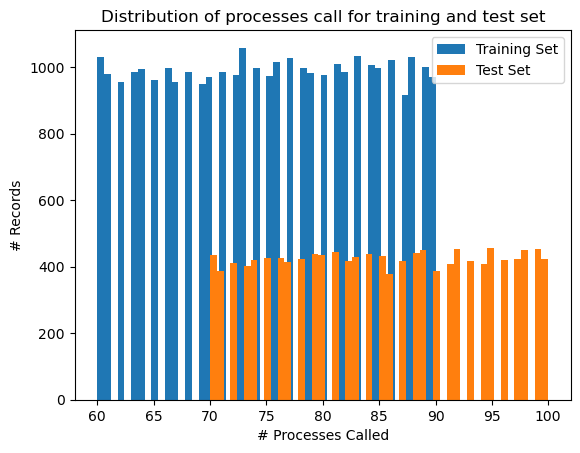

In [ ]:
print("Statistics about processes called per sample,for training set")
train_cardinality = [len(x) for x in train_df['api_call_sequence']]
df_train_cardinality = pd.DataFrame(train_cardinality)
display(df_train_cardinality.describe())


print("\nStatistics about processes called per sample,for test set")
test_cardinality = [len(x) for x in test_df['api_call_sequence']]
df_test_cardinality = pd.DataFrame(test_cardinality)
display(df_test_cardinality.describe())

plt.hist(df_train_cardinality,bins=50)
plt.hist(df_test_cardinality,bins=50)
plt.title(f'Distribution of processes call for training and test set')
plt.xlabel('# Processes Called')
plt.ylabel('# Records')
plt.legend(['Training Set','Test Set'])
plt.show()

From the graph above, we observe that the cardinality of processes in the training set ranges from 60 to 90, while in the test set, it ranges from 70 to 100. This dataset cannot be directly managed by a FeedForward Neural Network (FFNN) due to its variable size. Therefore, preprocessing techniques and workarounds are necessary to adapt this architecture.

An FFNN expects a fixed number of input features because the input layer is predefined with a specific number of nodes. The network architecture (number of neurons in each layer, their connections, and weights) is fixed once the model is built.

To handle variable input sizes, you can use techniques to preprocess or adapt the data:
- Padding or Truncating: Pad shorter inputs with a default value (e.g., zeros) or truncate longer inputs to a fixed size. This ensures all inputs are of uniform length.
- Feature Aggregation: Apply aggregation techniques such as averaging or summing across variable-length data to create a fixed-size representation.

### Sequential Identifier

*lack of semantic information !!*

Preprocessing of training set
- padding
- split in training and validation set

In [ ]:
unique_api_calls = set(api for seq in train_df['api_call_sequence'] for api in seq)
api_to_id = {api: index for index,api in enumerate(unique_api_calls)}

train_df["encoded_sequence"] = train_df["api_call_sequence"].apply(lambda seq: [api_to_id[api] for api in seq])

def pad_series(sequences,padding_value):
    max_length = max([len(x) for x in sequences])
    ret_value = np.full((len(sequences), max_length), padding_value, dtype=object)
    for idx, seq in enumerate(sequences):
        ret_value[idx, :len(seq)] = seq
    return ret_value

X_seq_id = pad_series(train_df['encoded_sequence'],0)
y_seq_id = y_train

# split training set to training and validate set
X_seq_id_train, X_seq_id_val, y_seq_id_train, y_seq_id_val = train_test_split(X_seq_id, y_seq_id, test_size=0.3, random_state=42)

# X_seq_id_train, y_seq_id_train
# X_seq_id_val, y_seq_id_val
# X_seq_id_test, y_seq_id_test

Processing the test set.
- managing out of vocabulary words
- padding
It has to be padded. The max length of the training set in 90, but on the test set it is 100. the only thing that we can do is to remove the extra values above 90.

In [ ]:
# To manage OOV words, in test set they will have a key not present in the dictionary
UNKNOWN_API_ID = len(api_to_id)
test_df["encoded_sequence"] = test_df["api_call_sequence"].apply(lambda seq: [api_to_id.get(api,UNKNOWN_API_ID) for api in seq])
X_seq_id_test = pad_series(test_df['encoded_sequence'],0)
y_seq_id_test = y_test

X_seq_id_pad_test = X_seq_id_test[:,:90]

In [ ]:
X_seq_id_train = np.array(X_seq_id_train, dtype=np.float32)
X_seq_id_val = np.array(X_seq_id_val, dtype=np.float32)
X_seq_id_pad_test = np.array(X_seq_id_pad_test, dtype=np.float32)


X_seq_id_train_tensor = torch.tensor(X_seq_id_train, dtype=torch.float32)
y_seq_id_train_tensor = torch.tensor(y_seq_id_train.tolist(), dtype=torch.long)
X_seq_id_val_tensor = torch.tensor(X_seq_id_val, dtype=torch.float32)
y_seq_id_val_tensor = torch.tensor(y_seq_id_val.tolist(), dtype=torch.long)

X_seq_id_test_tensor = torch.tensor(X_seq_id_pad_test, dtype=torch.float32)
y_seq_id_test_tensor = torch.tensor(y_seq_id_test.tolist(), dtype=torch.long)

In [ ]:
input_size = X_seq_id_train_tensor.shape[1]
output_size = len(torch.unique(y_seq_id_train_tensor))

In [ ]:
class FFNN1_Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super(FFNN1_Model, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Training loop with early stopping
def training_loop_with_minibatch(model, train_loader, val_loader, device, optimizer, criterion, num_epoch, patience, debug):
    num_epochs = num_epoch
    patience = patience  # Early stopping patience
    best_model_state_dict = model.state_dict()
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                epoch_val_loss += loss.item()

        val_losses.append(epoch_val_loss / len(val_loader))

        # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        if (epoch + 1) % 10 == 0 and debug == True :
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


        # Early stopping check
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            best_model_state_dict = model.state_dict()  # Save best model state
        else:
            patience_counter += 1

        if patience_counter >= patience:
            if debug == True:
                print("Early stopping triggered.")
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    if debug == True:
        print(f"Training completed in {elapsed_time:.2f} seconds.")

    # Load the best model state before returning
    model.load_state_dict(best_model_state_dict)

    # Plot training and validation losses
    if debug == True:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.yscale('log')
        plt.legend()
        plt.show()
    return model, train_losses, val_losses # Return the trained model and losses


In [ ]:
def testing_model(model, dataloader, device, debug):
    """
    Evaluate the model on a given dataloader and compute accuracy.

    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()

    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    if debug == True:
        print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy, all_labels, all_predictions

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.1, 1],
    'hidden_layers': [
        [32, 64],
        [64, 32, 16],
        [64,128,128,64]
    ],
    'batch_size': [16, 32,128],
    'optimizer': [
        {'name': 'SGD+Momentum(0.3)', 'opt': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.3)},
        {'name': 'SGD+Momentum(0.9)', 'opt': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)},
        {'name': 'AdamW', 'opt': lambda params, lr: optim.AdamW(params, lr=lr)}
    ]
}

In [ ]:
grid = list(ParameterGrid(param_grid))
print(f"Grid has {len(grid)} dimension\n")
best_model = None
best_accuracy = 0
best_params = None
best_train_losses = None
best_val_losses = None
best_test_accuracy = 0
best_test_labels = []
best_test_preds = []

all_train_losses = []
all_val_losses = []
all_test_accuracies = []

g = torch.Generator()
g.manual_seed(42)

for idx, params in enumerate(grid):
    print(f"{idx}/{len(grid)} Testing parameters: "
          f"Hidden layers: {params['hidden_layers']}, "
          f"Batch size: {params['batch_size']}, "
          f"Optimizer: {params['optimizer']['name']}, "
          f"lr: {params['learning_rate']})",end = "")

    model = FFNN1_Model(input_size, output_size,params['hidden_layers'])
    criterion = nn.CrossEntropyLoss()
    optimizer = params['optimizer']['opt'](model.parameters(), lr=params['learning_rate'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_dataset = TensorDataset(X_seq_id_train_tensor, y_seq_id_train_tensor)
    val_dataset = TensorDataset(X_seq_id_val_tensor, y_seq_id_val_tensor)
    test_dataset = TensorDataset(X_seq_id_test_tensor, y_seq_id_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, generator=g)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    model, train_losses, val_losses = training_loop_with_minibatch(model, train_loader, val_loader, device, optimizer, criterion,num_epoch = 100, patience = 20, debug = False)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    val_accuracy, _, _ = testing_model(model, val_loader, device, debug = False)
    #print(f"\tVal Accuracy: {val_accuracy:.2f}%")
    test_accuracy, test_labels, test_preds = testing_model(model, test_loader, device, debug = False)
    #print(f"\tTest Accuracy: {test_accuracy:.2f}%")
    print(f" - Test acc: {test_accuracy:.2f}%")
    #print(classification_report(test_labels, test_preds))

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_test_labels = test_labels
        best_test_preds = test_preds
        best_model = model
        best_params = params
        best_train_losses = train_losses
        best_val_losses = val_losses


Grid has 81 dimension

0/81 Testing parameters: Hidden layers: [32, 64], Batch size: 16, Optimizer: SGD+Momentum(0.3), lr: 0.001) - Test acc: 97.86%
1/81 Testing parameters: Hidden layers: [32, 64], Batch size: 16, Optimizer: SGD+Momentum(0.9), lr: 0.001) - Test acc: 97.74%
2/81 Testing parameters: Hidden layers: [32, 64], Batch size: 16, Optimizer: AdamW, lr: 0.001) - Test acc: 97.96%
3/81 Testing parameters: Hidden layers: [32, 64], Batch size: 16, Optimizer: SGD+Momentum(0.3), lr: 0.1) - Test acc: 97.54%
4/81 Testing parameters: Hidden layers: [32, 64], Batch size: 16, Optimizer: SGD+Momentum(0.9), lr: 0.1) - Test acc: 97.54%
5/81 Testing parameters: Hidden layers: [32, 64], Batch size: 16, Optimizer: AdamW, lr: 0.1) - Test acc: 97.54%
6/81 Testing parameters: Hidden layers: [32, 64], Batch size: 16, Optimizer: SGD+Momentum(0.3), lr: 1) - Test acc: 97.54%
7/81 Testing parameters: Hidden layers: [32, 64], Batch size: 16, Optimizer: SGD+Momentum(0.9), lr: 1) - Test acc: 97.54%
8/81 Te


Best model parameters: Hidden layers: [64, 128, 128, 64], Batch size: 32, Optimizer: SGD+Momentum(0.9), lr: 0.001)
Best test accuracy: 98.27%
              precision    recall  f1-score   support

           0       0.79      0.40      0.53       324
           1       0.99      1.00      0.99     12839

    accuracy                           0.98     13163
   macro avg       0.89      0.70      0.76     13163
weighted avg       0.98      0.98      0.98     13163



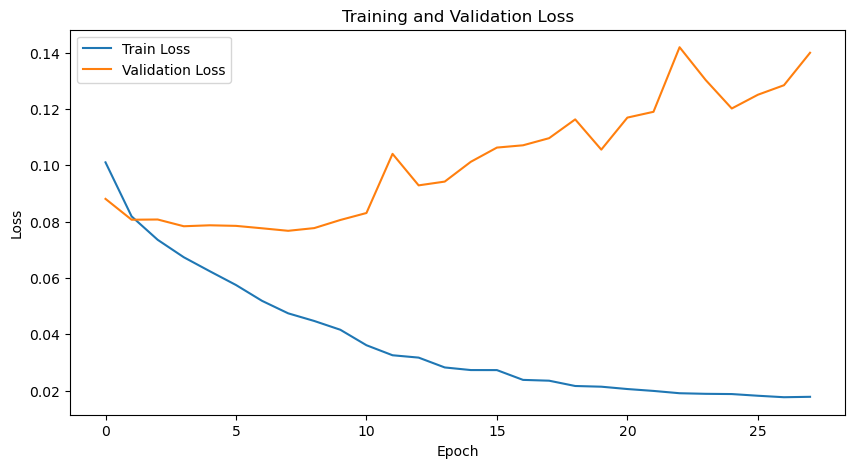

In [ ]:
print(f"\nBest model parameters: Hidden layers: {best_params['hidden_layers']}, "
          f"Batch size: {best_params['batch_size']}, "
          f"Optimizer: {best_params['optimizer']['name']}, "
          f"lr: {best_params['learning_rate']})")
print(f"Best test accuracy: {best_test_accuracy:.2f}%")
print(classification_report(best_test_labels, best_test_preds))

plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### learnable embeddings

## Task 3: Recursive Neural Network (RNN)
Next, use a Recursive Neural Network (RNN) to model your problem.
- Do you still have to pad your data? If yes, how?
- Do you have to truncate the testing sequences? Justify your answer with your under- standing of why it is/it is not the case.
- Is there any memory advantage on using an RNN wrt a FF when you process your dataset? Why?
- Start with a simple one-directional RNN. Is your network fast as the FF? If not, where do you think that time-overhead comes from?
- Train and tne three variations of networks:
  * Simple one-directional RNN
  * Bi-Directional RNN
  * LSTM (choose whether you want it one-directional or bi-directional)

  Can you see any differences during their training? Can you obtain the same

In [4]:
dataset_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab02/train.json'
train_df = pd.read_json(dataset_url)
dataset_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab02/test.json'
test_df = pd.read_json(dataset_url)

In [8]:
train_df['seq_length'] = train_df['api_call_sequence'].apply(len)
test_df['seq_length'] = test_df['api_call_sequence'].apply(len)
sequences = train_df['api_call_sequence'].tolist()
vocabulary = set()
for seq in sequences:
    vocabulary.update(seq)
vocabulary = sorted(list(vocabulary))  # Convert to sorted list for consistent indexing
# Create Mapping
api_to_index = {api: index for index, api in enumerate(vocabulary)}
print(api_to_index)

{'CertOpenStore': 0, 'CertOpenSystemStoreW': 1, 'CoCreateInstance': 2, 'CoCreateInstanceEx': 3, 'CoGetClassObject': 4, 'CoInitializeEx': 5, 'CoInitializeSecurity': 6, 'CoUninitialize': 7, 'CopyFileA': 8, 'CopyFileExW': 9, 'CopyFileW': 10, 'CreateActCtxW': 11, 'CreateDirectoryW': 12, 'CreateJobObjectW': 13, 'CreateProcessInternalW': 14, 'CreateServiceA': 15, 'CreateServiceW': 16, 'CreateThread': 17, 'CreateToolhelp32Snapshot': 18, 'CryptAcquireContextA': 19, 'CryptAcquireContextW': 20, 'CryptCreateHash': 21, 'CryptDecodeObjectEx': 22, 'CryptDecrypt': 23, 'CryptEncrypt': 24, 'CryptExportKey': 25, 'CryptGenKey': 26, 'CryptHashData': 27, 'CryptProtectData': 28, 'CryptProtectMemory': 29, 'DeleteFileW': 30, 'DeleteUrlCacheEntryA': 31, 'DeleteUrlCacheEntryW': 32, 'DeviceIoControl': 33, 'DnsQuery_A': 34, 'DrawTextExA': 35, 'DrawTextExW': 36, 'EnumServicesStatusA': 37, 'EnumWindows': 38, 'FindFirstFileExA': 39, 'FindFirstFileExW': 40, 'FindResourceA': 41, 'FindResourceExA': 42, 'FindResourceExW

<ipython-input-9-d9ddb6b299fb>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Not Malware (0)', 'Malware (1)'])


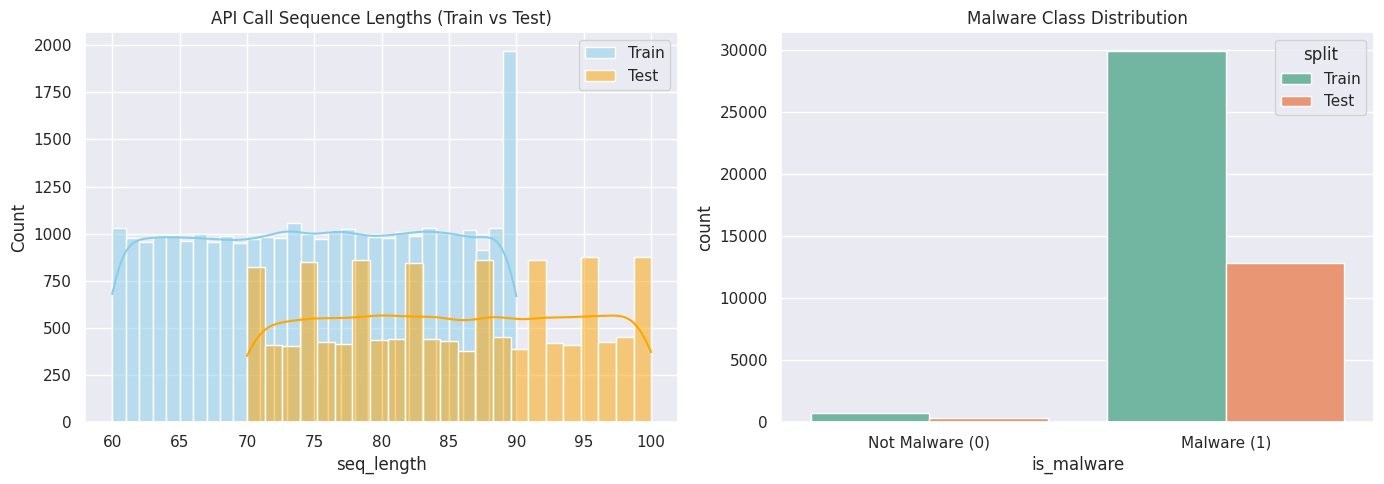

In [9]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=train_df, x='seq_length', kde=True, color="skyblue", label='Train', ax=axs[0])
sns.histplot(data=test_df, x='seq_length', kde=True, color="orange", label='Test', ax=axs[0])
axs[0].set_title("API Call Sequence Lengths (Train vs Test)")
axs[0].legend()
train_df['split'] = 'Train'
test_df['split'] = 'Test'
combined = pd.concat([train_df[['is_malware', 'split']], test_df[['is_malware', 'split']]])

sns.countplot(data=combined, x='is_malware', hue='split', palette="Set2", ax=axs[1])
axs[1].set_title("Malware Class Distribution")
axs[1].set_xticklabels(['Not Malware (0)', 'Malware (1)'])

plt.tight_layout()
plt.show()

In [10]:
train_size = int(0.8 * len(train_df))

In [19]:
df_train = train_df.iloc[:train_size].copy()
df_val = train_df.iloc[train_size:].copy()
print(df_train.shape)
print(df_val.shape)
print(df_train)

(24570, 5)
(6143, 5)
                                md5hash  \
0      aaec2a99e23b2478ce5ec7f9b43c840c   
1      14a9db02dd903a76adb275cf45d10413   
2      70f77a07109abab1983d98214f4eb199   
3      fa67eebd3047eb2a4c9379623219d58d   
4      d9209cdfe4fd24c6f2a17acdafa558a5   
...                                 ...   
24565  14cd3231b27bf79dded31a78c3febe44   
24566  764482604d5ad4730c2495d1c9f3b01b   
24567  8ad23327f1d58fe5840de51409d0d286   
24568  0452ac30d1220353af5284383baced85   
24569  abf9884783fd31e0fd40528e02299c07   

                                       api_call_sequence  is_malware  \
0      [NtClose, NtOpenKey, NtQueryValueKey, NtClose,...           1   
1      [GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...           1   
2      [RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...           1   
3      [RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...           1   
4      [NtClose, NtOpenKey, NtQueryValueKey, NtClose,...           1   
...                           

In [18]:
numerical_cols = df_train.select_dtypes(include=['number']).columns.tolist()
if 'api_call_sequence' in numerical_cols:
    numerical_cols.remove('api_call_sequence')

scaler = MinMaxScaler()

df_train_scaled = df_train.copy()
df_val_scaled = df_val.copy()
df_test_scaled = test_df.copy()

if numerical_cols:
    df_train_scaled[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
    df_val_scaled[numerical_cols] = scaler.transform(df_val[numerical_cols])
    df_test_scaled[numerical_cols] = scaler.transform(test_df[numerical_cols])
else:
    print("No numerical columns found to scale.")
df_train_scaled.head(10)

,md5hash,api_call_sequence,is_malware,seq_length,split,encoded
0,aaec2a99e23b2478ce5ec7f9b43c840c,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1.0,0.433333,Train,"[130, 147, 160, 130, 147, 160, 130, 113, 114, ..."
1,14a9db02dd903a76adb275cf45d10413,"[GetSystemTimeAsFileTime, LdrLoadDll, LdrGetPr...",1.0,0.933333,Train,"[78, 115, 114, 115, 114, 113, 114, 113, 114, 2..."
2,70f77a07109abab1983d98214f4eb199,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1.0,0.633333,Train,"[194, 147, 160, 130, 147, 160, 130, 154, 118, ..."
3,fa67eebd3047eb2a4c9379623219d58d,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1.0,0.366667,Train,"[194, 147, 160, 130, 147, 160, 130, 154, 118, ..."
4,d9209cdfe4fd24c6f2a17acdafa558a5,"[NtClose, NtOpenKey, NtQueryValueKey, NtClose,...",1.0,0.100000,Train,"[130, 147, 160, 130, 147, 160, 130, 113, 114, ..."
5,a0ceb320074d8b416cd70282e149c785,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1.0,0.366667,Train,"[194, 147, 160, 130, 147, 160, 130, 154, 118, ..."
6,a6066565c151652483e99c5e129d4b17,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1.0,0.700000,Train,"[194, 147, 160, 130, 147, 160, 130, 154, 118, ..."
7,087c6220fb60887f444b586221e0d3ed,"[GetSystemTimeAsFileTime, NtAllocateVirtualMem...",1.0,0.933333,Train,"[78, 129, 141, 129, 113, 114, 113, 129, 220, 1..."
8,a5be5336f78ac2105fba8dc6a7c792c9,"[GetSystemTimeAsFileTime, LdrGetDllHandle, Ldr...",1.0,0.466667,Train,"[78, 113, 114, 220, 115, 114, 72, 116, 174, 19..."
9,0ddba1e741e223f85c849fd4e29d81c7,"[RegOpenKeyExA, NtOpenKey, NtQueryValueKey, Nt...",1.0,0.033333,Train,"[194, 147, 160, 130, 147, 160, 130, 154, 118, ..."


Vocabulary size (with PAD and OOV): 255


<ipython-input-27-3c4f9845c16d>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Not Malware (0)', 'Malware (1)'])


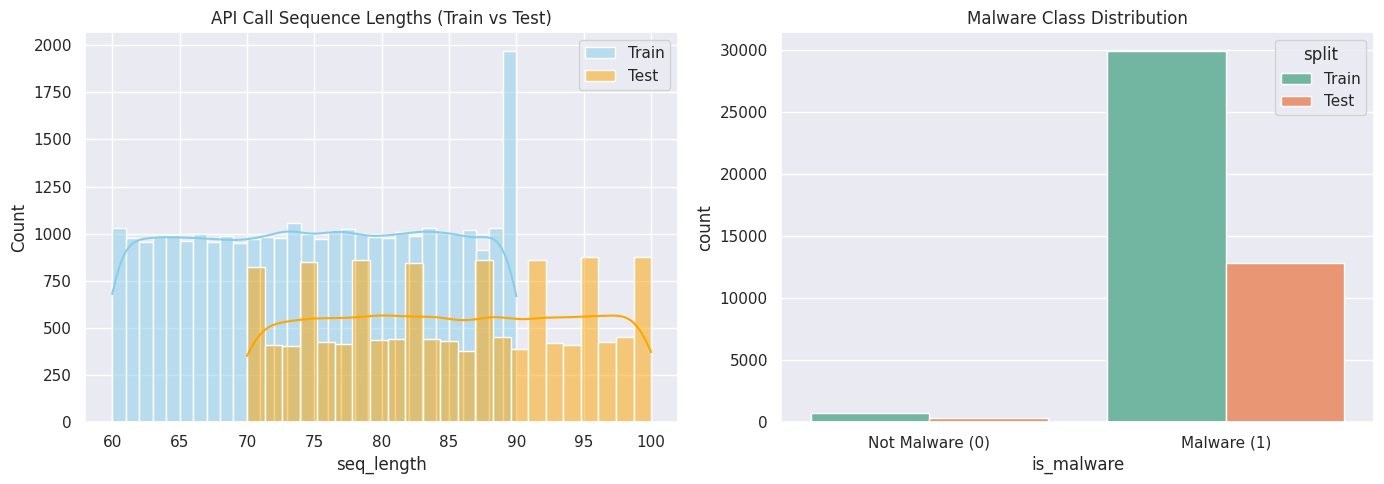

Out-of-Vocabulary Words: {'ObtainUserAgentString', 'ControlService', 'WSASocketA', 'WSARecv', 'NtDeleteKey'}
There are 5 out-of-vocabulary words
(24570, 5)
(6143, 5)


In [27]:
train_df['seq_length'] = train_df['api_call_sequence'].apply(len)
test_df['seq_length'] = test_df['api_call_sequence'].apply(len)

# Step 2: Vocabulary creation from train set only
sequences = train_df['api_call_sequence'].tolist()
vocabulary = set()
for seq in sequences:
    vocabulary.update(seq)
vocabulary = sorted(list(vocabulary))  # consistent indexing

# Step 3: Create mapping with special tokens: 0 = PAD, 1 = OOV
api_to_index = {api: idx + 2 for idx, api in enumerate(vocabulary)}
api_to_index["<PAD>"] = 0
api_to_index["<OOV>"] = 1
print("Vocabulary size (with PAD and OOV):", len(api_to_index))

# Step 4: Encode function
def encode_sequence(seq, mapping):
    return [mapping.get(api, mapping["<OOV>"]) for api in seq]

# Step 5: Visualizations
sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=train_df, x='seq_length', kde=True, color="skyblue", label='Train', ax=axs[0])
sns.histplot(data=test_df, x='seq_length', kde=True, color="orange", label='Test', ax=axs[0])
axs[0].set_title("API Call Sequence Lengths (Train vs Test)")
axs[0].legend()
train_df['split'] = 'Train'
test_df['split'] = 'Test'
combined = pd.concat([train_df[['is_malware', 'split']], test_df[['is_malware', 'split']]])
sns.countplot(data=combined, x='is_malware', hue='split', palette="Set2", ax=axs[1])
axs[1].set_title("Malware Class Distribution")
axs[1].set_xticklabels(['Not Malware (0)', 'Malware (1)'])
plt.tight_layout()
plt.show()

# Step 6: Out-of-Vocabulary check
test_vocab = set(api for seq in test_df["api_call_sequence"] for api in seq)
train_vocab = set(api for seq in train_df["api_call_sequence"] for api in seq)
oov_words = test_vocab - train_vocab
print("Out-of-Vocabulary Words:", oov_words)
print(f"There are {len(oov_words)} out-of-vocabulary words")

# Step 7: Train/validation split
train_size = int(0.8 * len(train_df))
df_train = train_df.iloc[:train_size].copy()
df_val = train_df.iloc[train_size:].copy()
print(df_train.shape)
print(df_val.shape)

# Step 8: Encode sequences
df_train['encoded_seq'] = df_train['api_call_sequence'].apply(lambda x: encode_sequence(x, api_to_index))
df_val['encoded_seq'] = df_val['api_call_sequence'].apply(lambda x: encode_sequence(x, api_to_index))
test_df['encoded_seq'] = test_df['api_call_sequence'].apply(lambda x: encode_sequence(x, api_to_index))

# Step 9: Pad sequences
MAX_LEN = 100
X_train = pad_sequences(df_train['encoded_seq'], maxlen=MAX_LEN, padding='post', truncating='post', value=api_to_index["<PAD>"])
X_val = pad_sequences(df_val['encoded_seq'], maxlen=MAX_LEN, padding='post', truncating='post', value=api_to_index["<PAD>"])
X_test = pad_sequences(test_df['encoded_seq'], maxlen=MAX_LEN, padding='post', truncating='post', value=api_to_index["<PAD>"])

# Step 10: Extract labels
y_train = df_train['is_malware'].values
y_val = df_val['is_malware'].values
y_test = test_df['is_malware'].values

In [67]:
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<ipython-input-67-89d2d4313cd6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long)
<ipython-input-67-89d2d4313cd6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-67-89d2d4313cd6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.long)
<ipython-input-67-89d2d4313cd6>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

In [71]:
class RNNMalwareClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, rnn_type='RNN', bidirectional=False):
        super(RNNMalwareClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.num_directions = 2 if bidirectional else 1

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError("Invalid RNN type. Choose 'RNN' or 'LSTM'.")

        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        rnn_out, _ = self.rnn(x)

        if self.rnn.bidirectional:
            rnn_out = torch.cat((rnn_out[:, -1, :self.rnn.hidden_size], rnn_out[:, -1, self.rnn.hidden_size:]), dim=1)
        else:
            rnn_out = rnn_out[:, -1, :]

        out = self.fc(rnn_out)
        out = self.sigmoid(out)
        return out

In [73]:
def training_loop(model, train_loader, val_loader, device, optimizer, num_epochs, criterion, model_type="RNN"): # Added model_type
    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch_X.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device).unsqueeze(1)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item() * batch_X.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'{model_type} Training took {elapsed_time:.4f} seconds')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_type} Training and Validation Loss')
    plt.legend()
    plt.show()

def testing_model(model, test_loader, device, model_type="RNN"):
    start_time = time.time()
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).unsqueeze(1)
            outputs = model(batch_X)
            predictions = (outputs > 0.5).float()
            all_labels.extend(batch_y.cpu().numpy().flatten())
            all_predictions.extend(predictions.cpu().numpy().flatten())

    # Calculate metrics (e.g., accuracy, precision, recall, F1)
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f'{model_type} Test Results:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'{model_type} Testing took {elapsed_time:.4f} seconds')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

VOCAB_SIZE = len(api_to_index)
EMBEDDING_DIM = 128
HIDDEN_SIZE = 128
OUTPUT_SIZE = 1

NUM_EPOCHS = 20
LEARNING_RATE = 0.001
CRITERION = nn.BCELoss()

# 1. Simple One-Directional RNN
print("--- One-Directional RNN ---")
rnn_model = RNNMalwareClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, OUTPUT_SIZE, rnn_type='RNN', bidirectional=False).to(device)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)
training_loop(rnn_model, train_loader, val_loader, device, rnn_optimizer, NUM_EPOCHS, CRITERION, model_type="One-Directional RNN")
testing_model(rnn_model, test_loader, device, model_type="One-Directional RNN")


# 2. Bi-Directional RNN
print("\n--- Bi-Directional RNN ---")
bi_rnn_model = RNNMalwareClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, OUTPUT_SIZE, rnn_type='RNN', bidirectional=True).to(device)
bi_rnn_optimizer = optim.Adam(bi_rnn_model.parameters(), lr=LEARNING_RATE)
training_loop(bi_rnn_model, train_loader, val_loader, device, bi_rnn_optimizer, NUM_EPOCHS, CRITERION, model_type="Bi-Directional RNN")
testing_model(bi_rnn_model, test_loader, device, model_type="Bi-Directional RNN")


# 3. Bi-Directional LSTM
print("\n--- Bi-Directional LSTM ---")
lstm_model = RNNMalwareClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, OUTPUT_SIZE, rnn_type='LSTM', bidirectional=True).to(device)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
training_loop(lstm_model, train_loader, val_loader, device, lstm_optimizer, NUM_EPOCHS, CRITERION, model_type="Bi-Directional LSTM")
testing_model(lstm_model, test_loader, device, model_type="Bi-Directional LSTM")

cpu
--- One-Directional RNN ---
Epoch 10/20, Train Loss: 0.1165, Val Loss: 0.1189


## Task 4: Graph Neural Network (GNN)
Finally, use a Graph Neural Network (GNN) to model your problem. Consider each sequence
of API call as a graph.
- Do you still have to pad your data? If yes, how?
- Do you have to truncate the testing sequences? Justify your answer with your under- standing of why it is/it is not the case.
- What is the advantage of modelling your problem with a GNN with respect to FFNN and RNN? What do you lose?
- Start creating a first simple GCN and train/test it on CPU first and GPU next. How long does it take for training and testing in each configuration? How does it differ with respect to previous architectures? Can you guess why
- Finally train and tune variations of GNN considering different message and aggregation functions and architectures:
    * Simple GCN
    * GraphSAGE
    * and GAT
    Can you see any differences during their training? Can you obtain the same